In [1]:
from sklearn.datasets import make_moons
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from torch import nn
import numpy as np

In [2]:
train , target = make_moons(n_samples=1000 , noise=0.1)
train_df = pd.DataFrame(train , columns=[f'feature{i}' for i in range(train.shape[1])])
target_df = pd.DataFrame(target , columns=['target'])

df = pd.concat([train_df , target_df] , axis=1)
df.head()

,feature0,feature1,target
0,-1.046811,0.486829,0
1,1.874762,0.382875,1
2,-0.010383,0.190387,1
3,0.688815,0.543660,0
4,0.736799,0.445551,0


In [3]:
from sklearn.model_selection import train_test_split 
xtrain , xtest , ytrain, ytest = train_test_split(train, target , test_size=0.2)
xtrain.shape , xtest.shape , ytrain.shape , ytest.shape


((800, 2), (200, 2), (800,), (200,))

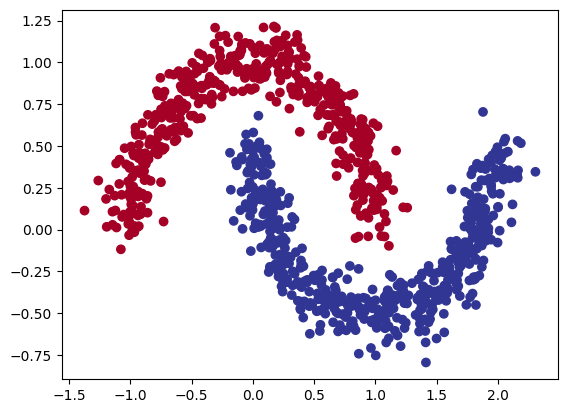

In [4]:
plt.scatter(train[:, 0] , train[:, 1] , c=target , cmap=plt.cm.RdYlBu)

In [5]:
train = torch.from_numpy(train).type(torch.float32)
target = torch.from_numpy(target).type(torch.float32)

In [6]:
class CircleModel(nn.Module): 
    def __init__(self): 
        super().__init__() 

        self.sequence = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8 , 4),
            nn.ReLU(),
            nn.Linear(4 , 1)
        )

    def forward(self , x:torch.tensor)->torch.tensor: 
        return self.sequence(x)
    

model = CircleModel() 

In [7]:
next(model.parameters()).device , model.state_dict()

(device(type='cpu'),
 OrderedDict([('sequence.0.weight',
               tensor([[-0.2527,  0.6234],
                       [ 0.3005,  0.3516],
                       [-0.1782,  0.3735],
                       [-0.5753, -0.0604],
                       [-0.2662, -0.2702],
                       [-0.2024, -0.2210],
                       [-0.6365, -0.1880],
                       [ 0.4431,  0.6957]])),
              ('sequence.0.bias',
               tensor([-0.0644,  0.5842, -0.4995, -0.0291, -0.4763,  0.2025,  0.1674, -0.5811])),
              ('sequence.2.weight',
               tensor([[ 0.0251, -0.1820, -0.0586,  0.2656, -0.1250,  0.1525, -0.0873,  0.2131],
                       [ 0.2993,  0.2716,  0.2814, -0.0644,  0.1885, -0.0166,  0.1793, -0.0980],
                       [-0.1176, -0.2066,  0.2110, -0.2042, -0.0310,  0.3341, -0.2849,  0.1336],
                       [-0.3212,  0.1483,  0.2393, -0.3437,  0.0625, -0.0776,  0.1391, -0.2550]])),
              ('sequence.2.bias',
   

In [8]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters() , lr=0.1)

In [9]:
def measure_metrics(ypred, ytrue):
    from torchmetrics import Accuracy
    accuracy = Accuracy(task='multiclass', num_classes=3)
    return {
        "accuracy": accuracy(ypred, ytrue)
    }


In [10]:
def convert_to_tensor(array): 
    return torch.from_numpy(array).type(torch.float)

In [11]:
epochs = 50
acclist = []
losslist = []
testacc = []
testloss = []
accuracyLoss =[]

for epoch in range(epochs): 
        model.train() 
        ylogit = model(convert_to_tensor(xtrain)).squeeze()
        ypred = (torch.sigmoid(ylogit) >= 0.5).long()
        loss = loss_fn(ylogit , convert_to_tensor(ytrain))
        losslist.append(loss.item())
        accuracy = measure_metrics(ypred , convert_to_tensor(ytrain))
        acclist.append(accuracy['accuracy'].item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  

        # evaluation 
        model.eval()
        testLogit = model(convert_to_tensor(xtest)).squeeze()
        testPred = (torch.sigmoid(testLogit)>= 0.5).long()
        loss = loss_fn(testLogit , convert_to_tensor(ytest))
        testloss.append(loss.item())
        accuracy = measure_metrics(testPred , convert_to_tensor(ytest))
        accuracyLoss.append(accuracy['accuracy'].item())



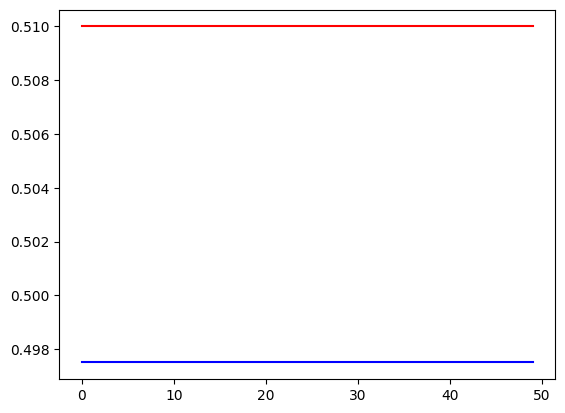

In [12]:
fig, axes = plt.subplots()
axes.plot(acclist , label = 'train' , color='blue')
axes.plot(accuracyLoss, label = 'test' , color = 'red')

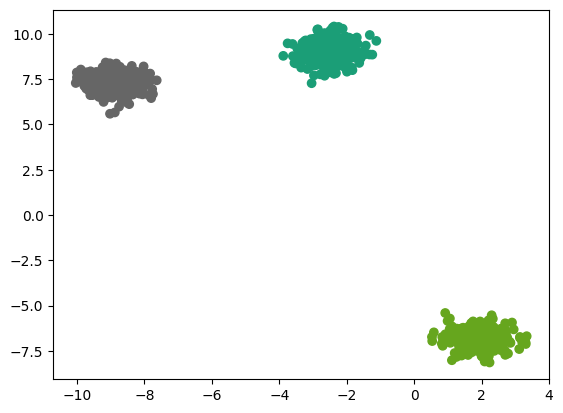

In [13]:
from sklearn.datasets import make_blobs
train , target = make_blobs(n_samples=1000 , n_features=3 , cluster_std=0.5 , random_state=42)

plt.scatter(train[:,0], train[:, 1], c=target ,cmap=plt.cm.Dark2 )

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(train , target , test_size=0.2 , stratify=target)
xtrain.shape , xtest.shape , ytrain.shape , ytest.shape

((800, 3), (200, 3), (800,), (200,))

In [15]:
def normalize_data(xtrain, xtest, ytrain = None, ytest = None): 
    from sklearn.preprocessing import MinMaxScaler

    # Normalize features
    x_scaler = MinMaxScaler()
    xtrain_scaled = x_scaler.fit_transform(xtrain)
    xtest_scaled = x_scaler.transform(xtest)

    return xtrain_scaled, xtest_scaled


In [16]:
xtrain , xtest = normalize_data(xtrain , xtest)

In [17]:
class MultiClassModel(nn.Module): 
    def __init__(self): 
       super().__init__() 

       self.seqModel = nn.Sequential(
            nn.Linear(3, 8), 
            nn.Sigmoid(),
            nn.Linear(8 , 4),
            nn.Sigmoid(),
            nn.Linear(4, 3), 
        )

    def forward(self, x): 
        return self.seqModel(x)

In [18]:
model = MultiClassModel()

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-1)

In [24]:
epochs = 250
trainLoss = []
testLoss = []

trainacc = []
testacc = []

for epoch in range(epochs) : 
    model.train()
    ylogit = model(convert_to_tensor(xtrain))
    ypred = torch.softmax(ylogit, dim=1).argmax(dim=1)
    loss = loss_fn(ylogit , convert_to_tensor(ytrain).long())
    trainLoss.append(loss.item())
    acc = measure_metrics(ypred ,  convert_to_tensor(ytrain).long())
    trainacc.append(acc['accuracy'].item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode(): 
        ytestlogit = model(convert_to_tensor(xtest))
        loss =  loss_fn(ylogit , convert_to_tensor(ytrain).long())
        testloss.append(loss.item())
        ypred = torch.softmax(ytestlogit, dim=1).argmax(dim=1).long()
        acc = measure_metrics(ypred , convert_to_tensor(ytest).long())
        testacc.append(acc['accuracy'].item())


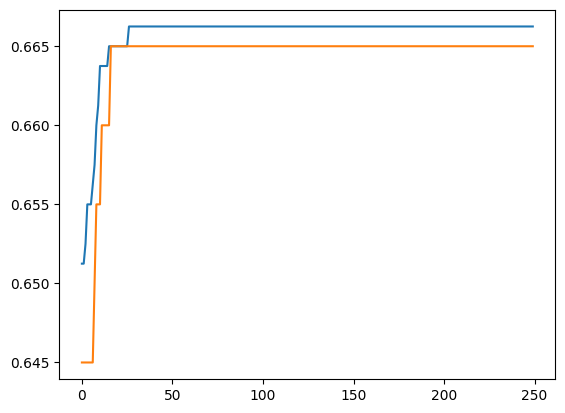

In [25]:
plt.plot(trainacc)
plt.plot(testacc)